In [2]:
# load all previous fake news domains for retrospective analysis and visualization to identify suspicious clusters
# need to introduce certain thresholds
# visualize domain redirection chain with d3js

import os
import json
from pprint import pprint
from urllib.parse import urlparse
import util
from collections import defaultdict, Counter
import pandas as pd

def get_redirection_chain(document, edge_type):
    has_frontend_redirect = False
    previous_url = urlparse(document['url']).netloc
    # 1. init sub_redirect_chain with the first level URL
    sub_redirect_chain = [previous_url]
    
    # we need a map of url --> ip
    url_ip_map = {}
    for entry in document["network_communication"]:
        # check if remoteIPAddress points to NYU IP (no such case find)
        if '216.165' in entry['remoteIPAddress']:
            pprint(entry)
        normalized_url = util.get_normalized_domain(entry['url'])
        url_ip_map[normalized_url] = entry['remoteIPAddress']
        
    for index, chain in enumerate(document["redirection_chain"]):
        method = chain['method']
        
        if method == 'Page.frameScheduledNavigation':
            url_domain = urlparse(chain['url']).netloc
            if url_domain != previous_url:
                edge_type[(sub_redirect_chain[-1], url_domain)] = 'client_side'
                sub_redirect_chain.append(url_domain)
                has_frontend_redirect = True
            previous_url = urlparse(chain['url']).netloc

        if method == 'Network.requestWillBeSent':
            url_from = urlparse(chain['from_url']).netloc
            url_to = urlparse(chain['to_url']).netloc
            if url_from == previous_url and url_from != url_to:
                edge_type[(sub_redirect_chain[-1], url_to)] = 'server_side'
                sub_redirect_chain.append(url_to)
                previous_url = url_to
    
    return has_frontend_redirect, url_ip_map, sub_redirect_chain, document["network_communication"]

prefix = 'concat'
# prefix = 'cnnews3_com'
directory = '/Users/zc/Documents/TwitterBotProject/malicious_domain/{}/'.format(prefix)
graph_type = 'domain'  # domain | ip


nodes = {}
links = defaultdict(int)
counter = 0
no_ip = 0
no_redirect = 0
has_redirect = 0
last_domain = set([])
first_domain = set([])
temp_count = 0
valid_first_ips = defaultdict(list)
in_degree = Counter()
domain_status = {}
import re
phrase = re.compile('ww[0-9]+')
import os
import glob
first_domain_info = []
valid_first_ips = defaultdict(list)

for filename in os.listdir(directory):
    # load trace.json if it exists
    if os.path.isfile('{}/{}/trace.json'.format(directory, filename)):
        trace = json.load(open('{}/{}/trace.json'.format(directory, filename), 'r'))
        if any([r['is_redirect'] for r in trace['record']]):
                final_chain = []
                domain_ip = {}
                for r in trace['record']:
                    _, url_ip_map, res, net_comm = get_redirection_chain(r['record'], {})
                    if len(final_chain) == 1 and final_chain[0] == res[0]:
                        final_chain = res
                        domain_ip = url_ip_map
                    else:
                        final_chain += res
                        domain_ip.update(url_ip_map)
                        
                # skip non-redirection chains
                final_chain = [url.replace('www.', '') for url in final_chain]
                if len(final_chain) < 2:
                    print('WRONG DATA FORMAT')
                    pprint(final_chain)
                    domain_status[trace['input_url']] = 'other_error'
                    continue
                    
                if final_chain[-1] in ['hugedomains.com', 'domainmarket.com']:
                    no_ip += 1
                    domain_status[trace['input_url']] = 'for_sale'
                    print('domain_for_sale')
                    print(final_chain)
                    continue
                    
                if len(final_chain) == 2 and final_chain[-1] == final_chain[-2]:
                    no_redirect += 1
                    domain_status[trace['input_url']] = 'no_redirect'
                    continue
                        
                ##### translate domains to IPs ###############
                if graph_type == 'ip':
                    new_final_chain = []
                    pass_url = False
                    for url in final_chain:
                        if url not in domain_ip:
                            print("NO URL: ", url)
                            new_final_chain.append(str(temp_count))
                            temp_count += 1
                            pass_url = True
                        else:
                            new_final_chain.append(domain_ip[url])

                    if pass_url:
                        continue
                    final_chain = new_final_chain
            
#                 final_chain = [domain_ip[url.replace('www.', '')] for url in final_chain]
                #############################################
                
                # reformat final_chain to remove cycles
                previous_url = defaultdict(int)
                new_final_chain = []
                for url in final_chain:
                    num = previous_url[url]
                    if num == 0:
                        new_final_chain.append(url)
                    else:
                        new_final_chain.append('{}_LOOP_{}'.format(url, num))
                    previous_url[url] += 1
                
                # add node, edge
                final_chain = new_final_chain

                if len(final_chain) != len(set(final_chain)):
                    print('duplicate detected!')
                
                ## identify high in-degree nodes
                suspicious_domains = {
#                  '4179.roberat.com',
#                  '5751.roberat.com',
                 'bidr.trellian.com',
#                  'domain.dot.tk',
                 'dprtb.com',
#                  'instagram.com',
                 'park.above.com',
#                  'politicono.com',
#                  'usa.jared-don.com',
                 'usd.jared-don.com'}

                if len(set(final_chain).intersection(suspicious_domains)) == 0:
                    continue
                
                if 'api.quotes.com' in final_chain or 'usd.jared-don.com' in final_chain or '7075.roberat.com' in final_chain:
                    continue
                
                first_domain_info.append({
                    'url': final_chain[0],
                    'second_hop': final_chain[1],
                    'last_hop': final_chain[-1]
                })
                    
                valid_first_ips['tier_1'].append((final_chain[0], None))
                valid_first_ips['tier_2'].append((final_chain[1], None))
                valid_first_ips['tier_3'].append((final_chain[-1], None))
                    
                    
                for index, url in enumerate(final_chain[:-1]): 
                    if url not in nodes:
                        nodes[url] = counter
                        counter += 1
                    if final_chain[index+1] not in nodes:
                        nodes[final_chain[index+1]] = counter
                        counter += 1
                    links[(nodes[url], nodes[final_chain[index+1]])] += 1
                in_degree[final_chain[1]] += 1
                has_redirect += 1
                domain_status[trace['input_url']] = 'has_redirect'
        else:
            if len(trace['record']) == 1:
                    rchain = trace['record'][0]['record']['redirection_chain'] 
                    if len(rchain) == 1 and rchain[0]['url'] == "chrome-error://chromewebdata/":
#                         print(trace['error'])
                        no_ip += 1
                        domain_status[trace['input_url']] = 'other_error'
                    else:
                        # TODO: there are more subcases here
                        # Godaddy redirection tag 'reqp'
                        # wwX redirection: 'ww5',  'ww2', etc,.
                        # other domain on sale (need to parse HTML to get the information)
                        # other Internal server error http://newsiosity.com/
                        # I think len(trace['record']) == 2, no_redirection is most likely to be active true news
                        if len(rchain) == 0:
                            no_ip += 1
                            pprint('STRANGE! redirection chain is empty')
                            pprint(trace)
                            domain_status[trace['input_url']] = 'other_error'
                            continue
                            
                        if 'url' in rchain[-1]:
                            if 'cgi-sys/defaultwebpage.cgi' in rchain[-1]['url']:
                                pprint(rchain)
                                domain_status[trace['input_url']] = 'no_ip'
                                no_ip += 1
                            elif 'reqp' in rchain[-1]['url']:
                                pprint(rchain)
                                domain_status[trace['input_url']] = 'parked_domain'
                                no_ip += 1
                            elif len(re.findall(phrase, rchain[-1]['url'])) > 0:
                                domain_status[trace['input_url']] = 'has_redirect'
                                has_redirect += 1
                            elif 'chrome-error://chromewebdata' in rchain[-1]['url']:
                                domain_status[trace['input_url']] = 'server_error'
                                no_ip += 1
                            
                            # TODO: we also need to check for pages that have 500, 5XX errors on the web page, 
                            # one heuristic is to check for file size, or use keyword search on the home page
                            # example website: http://encyclopediadramatica.rs/ 503 error
                            # example website: http://elkoshary.com/ 500 error
                            else:
                                # calculate file size if there is only one html file
                                # get all html files 
                                
                                htmls = glob.glob('{}/{}/*.html'.format(directory, filename))
                                if len(htmls) != 1:
                                    print('something is very wrong!')
                                    pprint(rchain)
                                file_size = os.path.getsize(htmls[0])
                                
                                THRESHOLD = 1000
                                if file_size < THRESHOLD:
#                                     print(file_size)
#                                     print(trace['input_url'])
                                    domain_status[trace['input_url']] = 'server_error'
                                    no_ip += 1
                                else:
#                                     pprint(rchain)            
#                                     print(trace['input_url'])
#                                     print()
                                    # TODO: get redirection chain !!!
                                    no_redirect += 1
                                    domain_status[trace['input_url']] = 'no_redirect'
                        else:
                            no_redirect += 1
                            domain_status[trace['input_url']] = 'no_redirect'
                            
            else:
                if len(trace['record']) == 0:
                    if trace['error'] == 'cannot resolve IP address':
                        no_ip += 1
                        domain_status[trace['input_url']] = 'no_ip'
                    else:
                        domain_status[trace['input_url']] = 'server_error'

                else:
#                     _, url_ip_map, res, _ = get_redirection_chain(trace['record'][0]['record'], {})
#                     pprint(res)
#                     _, url_ip_map, res, _ = get_redirection_chain(trace['record'][1]['record'], {})
#                     pprint(res)
#                     pprint(trace['record'][1]['record']['redirection_chain'])
#                     print()
                    no_redirect += 1
                    domain_status[trace['input_url']] = 'no_redirect'
                
    else:
        print('trace does not exist')
        print(filename)

        
# we need to direct cycles
# what algorithm is efficient?
# https://www.geeksforgeeks.org/detect-cycle-in-a-graph/
# we need to find the exact path that has cycle
from collections import defaultdict 
  
class Graph(): 
    def __init__(self,vertices): 
        self.graph = defaultdict(list) 
        self.V = vertices 
  
    def addEdge(self,u,v): 
        self.graph[u].append(v) 
  
    def isCyclicUtil(self, v, visited, recStack): 
  
        # Mark current node as visited and  
        # adds to recursion stack 
        visited[v] = True
        recStack[v] = True
  
        # Recur for all neighbours
        # if any neighbour is visited and in  
        # recStack then graph is cyclic 
        for neighbour in self.graph[v]: 
            if visited[neighbour] == False: 
                if self.isCyclicUtil(neighbour, visited, recStack) == True: 
                    print(v, neighbour)
                    return True
            elif recStack[neighbour] == True: 
                return True
  
        # The node needs to be poped from  
        # recursion stack before function ends 
        recStack[v] = False
        return False
  
    # Returns true if graph is cyclic else false 
    def isCyclic(self): 
        visited = [False] * self.V 
        recStack = [False] * self.V 
        for node in range(self.V): 
            if visited[node] == False: 
                if self.isCyclicUtil(node,visited,recStack) == True: 
                    return True
        return False

# nodes
# links
# we need a reverse dictionary
g = Graph(len(nodes)) 
for key in links:
    g.addEdge(key[0], key[1]) 

if g.isCyclic() == 1: 
    print("Graph has a cycle")
else: 
    print("Graph has no cycle")

total = no_redirect + has_redirect + no_ip
print(no_redirect, no_redirect / total, no_redirect / (no_redirect + has_redirect))
print(has_redirect, has_redirect / total, has_redirect / (no_redirect + has_redirect))
print(no_ip, no_ip / total)

print(first_domain.intersection(last_domain))
print(first_domain)


[{'method': 'Page.frameNavigated', 'url': 'http://bullionbullscanada.com/'},
 {'method': 'Page.frameScheduledNavigation',
  'url': 'http://bullionbullscanada.com/?reqp=1&reqr='},
 {'method': 'Page.frameNavigated',
  'url': 'http://bullionbullscanada.com/?reqp=1&reqr='}]
something is very wrong!
[{'from_url': 'http://americanpressinstitute.org/',
  'method': 'Network.requestWillBeSent',
  'to_url': 'https://americanpressinstitute.org/'},
 {'method': 'Page.frameNavigated',
  'url': 'https://americanpressinstitute.org/'}]
domain_for_sale
['powerpoliticians.com', 'domainmarket.com']
domain_for_sale
['worldstoriestoday.com', 'hugedomains.com']
domain_for_sale
['fanzinger.com', 'hugedomains.com']
[{'method': 'Page.frameNavigated', 'url': 'http://en.hawarnews.com/'},
 {'method': 'Page.frameScheduledNavigation',
  'url': 'http://en.hawarnews.com/cgi-sys/defaultwebpage.cgi'},
 {'method': 'Page.frameNavigated',
  'url': 'http://en.hawarnews.com/cgi-sys/defaultwebpage.cgi'}]
[{'method': 'Page.fra

domain_for_sale
['professionalmac.com', 'hugedomains.com']
domain_for_sale
['badsquad.com', 'hugedomains.com']
domain_for_sale
['topratedviral.com', 'hugedomains.com']
[{'from_url': 'http://tdtalliance.com/',
  'method': 'Network.requestWillBeSent',
  'to_url': 'http://tdtalliance.com/'},
 {'method': 'Page.frameNavigated', 'url': 'http://tdtalliance.com/'},
 {'method': 'Page.frameScheduledNavigation',
  'url': 'http://tdtalliance.com/?reqp=1&reqr='},
 {'method': 'Page.frameNavigated',
  'url': 'http://tdtalliance.com/?reqp=1&reqr='}]
domain_for_sale
['uconservative.com', 'hugedomains.com']
domain_for_sale
['positivedaily.com', 'hugedomains.com']
domain_for_sale
['deepstatenation.com', 'hugedomains.com']
domain_for_sale
['uspostman.com', 'hugedomains.com']
domain_for_sale
['freedomsfinalstand.com', 'hugedomains.com']
domain_for_sale
['thenationalsun.com', 'domainmarket.com']
domain_for_sale
['akkadiantimes.com', 'domainmarket.com']
domain_for_sale
['conservativeheadlines.com', 'hugedoma

In [3]:
print(len(nodes))
print(len(links))
from collections import Counter
from query_viewdns import collect_ip_info_json
ips = {k: dict(Counter(v)) for k, v in valid_first_ips.items()}
filename = 'ip_domain_by_tier_{}.json'.format(prefix)
# pprint(ips)
# collect_ip_info_json(ips, filename)
# valid_first_ips

import copy
# filter out irrelevant redirection path
suspicious_domains = set([i[0] for i in in_degree.most_common(10)])
# new_links = {}
# for entry in links:
#     if entry[0] in suspicious_domains or entry[1] in suspicious_domains:
#         new_links[entry] = links[entry]
# links = new_links

65
66


In [4]:
suspicious_domains

{'bidr.trellian.com', 'dprtb.com', 'park.above.com'}

In [5]:
concat_suspicious = pd.DataFrame(in_degree.most_common(10), columns=['domain', 'number of connected fake news domains'])
print(concat_suspicious.to_latex(index=False))

concat_suspicious.to_clipboard(sep=',', index=True)




\begin{tabular}{lr}
\toprule
            domain &  number of connected fake news domains \\
\midrule
    park.above.com &                                     12 \\
         dprtb.com &                                      9 \\
 bidr.trellian.com &                                      3 \\
\bottomrule
\end{tabular}



In [6]:
nodes = list(map(lambda x: {'name': x[0], 'node': x[1]}, nodes.items()))
links = list(map(lambda x: {'source': x[0][0], 'target': x[0][1], 'value': x[1]}, links.items()))

In [14]:
tier_1_domain = set([entry[0] for entry in valid_first_ips['tier_1']])
tier_2_domain = set([entry[0] for entry in valid_first_ips['tier_2']])
tier_3_domain = set([entry[0] for entry in valid_first_ips['tier_3']])

# tier_2_domain.remove('click.appcast.io')
tier_3_domain.remove('click.appcast.io')

print(tier_1_domain)
for node in nodes:
    print(node['name'])
    if node['name'] in tier_1_domain:
        node['tier'] = 'tier_1'
    elif node['name'] in tier_2_domain:
        node['tier'] = 'tier_2'
    elif node['name'] in tier_3_domain:
        node['tier'] = 'tier_3'
    else:
        node['tier'] = 'other'


{'nmws.us', 'theexaminer.site', 'ladylibertynews.com', 'offendedamerica.com', 'organicandhealthy.org', 'buzzfeedusa.com', 'dailynews10.com', 'anonnews.co', 'thecontroversialfiles.net', 'nbc9news.com', 'ilovenativeamericans.us', 'usadailypost.us', 'embols.com', 'cooltobeconservative.com', 'movingleft.com', 'conservativeinfocorner.us', 'cvikasdrv.com', 'americanupdater.com', 'fergieinfo.com', 'randpaulreview.com', 'usadailypolitics.com', 'americanprides.org', 'dailyusaupdate.com', 'smoloko.com'}
movingleft.com
dprtb.com
1496.roberat.com
greatbritainlisted.com
joblookup.com
ladylibertynews.com
americanlisted.com
rd.purejobalerts.com
click.appcast.io
feed.int.jobble.com
info.jobble.com
cooltobeconservative.com
park.above.com
c.channeltraffic.net
11164440.searchiq.co
thesecuredweb.com
usadailypolitics.com
careerbliss.com
trk.careerbliss.com
click.appcast.io_LOOP_1
linkedin.com
embols.com
clk.rtpdn11.com
utorrent.en.softonic.com
cvikasdrv.com
gettruckerjobs.com
theexaminer.site
organicandhea

In [15]:

if graph_type == 'domain':
    json.dump({'nodes': nodes, 'links': links}, open('MonitorWebApp/templates/sankey_{}.json'.format(prefix), 'w'))
else:
    json.dump({'nodes': nodes, 'links': links}, open('MonitorWebApp/templates/sankey_{}_ip.json'.format(prefix), 'w'))

In [12]:
{'nodes': nodes, 'links': links}

{'nodes': [{'name': 'movingleft.com', 'node': 0, 'tier': 'tier_1'},
  {'name': 'dprtb.com', 'node': 1, 'tier': 'tier_2'},
  {'name': '1496.roberat.com', 'node': 2, 'tier': 'other'},
  {'name': 'greatbritainlisted.com', 'node': 3, 'tier': 'other'},
  {'name': 'joblookup.com', 'node': 4, 'tier': 'tier_3'},
  {'name': 'ladylibertynews.com', 'node': 5, 'tier': 'tier_1'},
  {'name': 'americanlisted.com', 'node': 6, 'tier': 'other'},
  {'name': 'rd.purejobalerts.com', 'node': 7, 'tier': 'other'},
  {'name': 'click.appcast.io', 'node': 8, 'tier': 'tier_2'},
  {'name': 'feed.int.jobble.com', 'node': 9, 'tier': 'other'},
  {'name': 'info.jobble.com', 'node': 10, 'tier': 'tier_3'},
  {'name': 'cooltobeconservative.com', 'node': 11, 'tier': 'tier_1'},
  {'name': 'park.above.com', 'node': 12, 'tier': 'tier_2'},
  {'name': 'c.channeltraffic.net', 'node': 13, 'tier': 'other'},
  {'name': '11164440.searchiq.co', 'node': 14, 'tier': 'other'},
  {'name': 'thesecuredweb.com', 'node': 15, 'tier': 'tier_3

In [52]:
df = pd.DataFrame(first_domain_info)
df.to_csv('suspicious_domain_fake_news_concat.csv', index=False)

In [53]:
import requests

def transfer(x_in):
    x_out = util.get_normalized_domain(x_in)
    return x_out

def mbfc_src_to_df():
#     source = requests.get('https://raw.githubusercontent.com/drmikecrowe/mbfcext/master/docs/revised/csources.json')
#     src = source.json()
#     df = pd.DataFrame(src.values())
#     df = df.rename(columns={"d": "domain", "b": "bias", "r": "factual_rating"})
    df = pd.read_csv("seed_files/mbfc_fake_list.csv")
    df['domain'] = df['domain'].apply(lambda x: transfer(x))
    print(len(df))
    # remove duplicate
    df = df.drop_duplicates(subset="domain", keep='first')
    df['factual_rating'] = df['factual_rating'].fillna('SATIRE')
#     df.to_csv("seed_files/mbfc_fake_list.csv")
    print(len(df))
    return df[['domain', 'bias', 'factual_rating']]
        
# example use case:
df_mbfc = mbfc_src_to_df()

set(df_mbfc['factual_rating'])


2793
2793


{'HIGH', 'LOW', 'MIXED', 'MOSTLY FACTUAL', 'SATIRE', 'VERY HIGH', 'VERY LOW'}

In [9]:
import ast

df_concat = pd.read_csv('seed_files/concat_fake_list.csv', index_col=None)
df_concat['source'] = df_concat['source'].apply(lambda x: ast.literal_eval(x))
del df_concat['Unnamed: 0']

# df_concat = pd.merge(df_concat, df_mbfc, how='right', on='domain')
# df_concat['is_fake'] = df_concat.apply(lambda x: is_true_news_from_mbfc(x), axis=1)
# df_concat = df_concat[df_concat['is_fake']]
# df_concat[df_concat.source.apply(lambda x: 'mbfc' in x)]


number of domains: 1395 mbfc


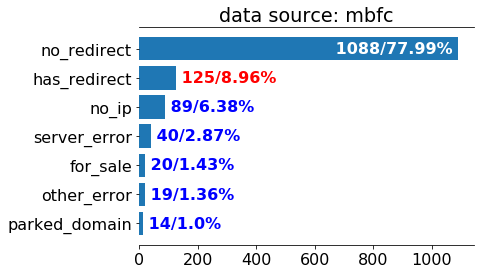

number of domains: 325 politifact


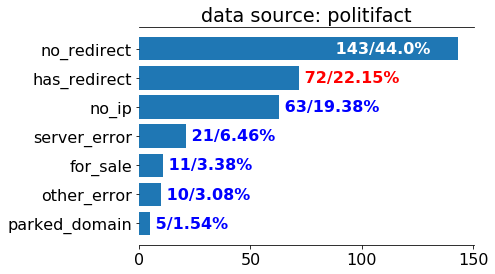

number of domains: 992 opensources


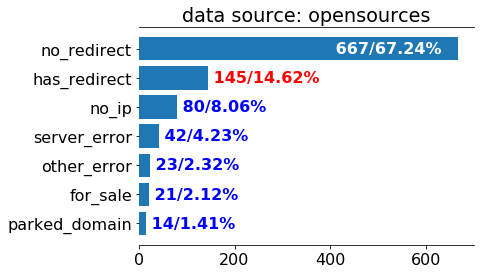

number of domains: 129 buzzfeed


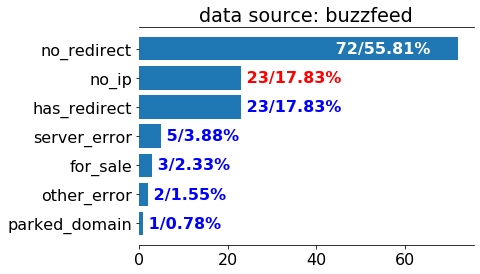

number of domains: 375 allcott


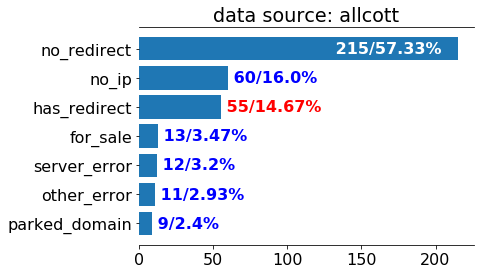

number of domains: 2300 all


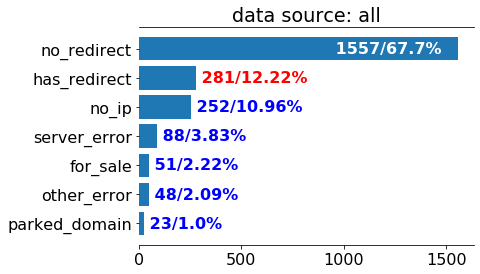

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import seaborn as sns

import numpy as np

df_merged = pd.merge(df_concat, df_mbfc, how='left', on='domain')
# df_merged[df_merged['source'].tolist()]

def is_true_news_from_mbfc(x):
    if len(x['source']) == 1 and x['source'][0] == 'mbfc':
        if x['factual_rating'] in set(['LOW', 'MIXED', 'VERY LOW', 'SATIRE']):
            return True
        else:
            return False
    else:
        return True

def get_domain_status(x):
    return domain_status.get(x['domain'], None)

df_merged['is_fake'] = df_merged.apply(lambda x: is_true_news_from_mbfc(x), axis=1)
df_merged['status'] = df_merged.apply(lambda x: get_domain_status(x), axis=1)


latex_table = []
df_lists = []
for source in ['mbfc', 'politifact', 'opensources', 'buzzfeed', 'allcott', 'all']:
    # get a temp dataframe that comes from that source
    plt.rcParams.update({'font.size': 16})

    df_temp = df_merged[df_merged['is_fake']]
    if source != 'all':
        df_temp = df_temp[df_temp.source.apply(lambda x: source in x)]
    print('number of domains: {} {}'.format(len(df_temp['domain']), source))
    
    result = df_temp.groupby(['status'])['domain'].count()
    x_label = list(result.index)

    res_label = zip(x_label, result)
    res_label = sorted(res_label, key=lambda x: x[1])
    result = [i[1] for i in res_label]
    x_label = [i[0] for i in res_label]
    
    x_pos = range(1, len(result) + 1)

    plt.barh(x_pos, result, align='center')

    total = sum(result)
    result_percent = [str(np.round(num*100/total, 2))+'%' for num in result]
    df_lists.append([source, total] + result_percent[::-1])
    
    for i, v in enumerate(result):
        if i == 5 and source != 'allcott':
            plt.text(v, i+1, " "+str(v) + "/" + result_percent[i], color='red', va='center', fontweight='bold')
        elif i == 4 and source == 'allcott':
            plt.text(v, i+1, " "+str(v) + "/" + result_percent[i], color='red', va='center', fontweight='bold')
        elif i == 6:
            plt.text(v * 0.6, i+1, " "+str(v) + "/" + result_percent[i], color='white', va='center', fontweight='bold')
        else:
            plt.text(v, i+1, " "+str(v) + "/" + result_percent[i], color='blue', va='center', fontweight='bold')

    plt.title('data source: {}'.format(source))
    plt.yticks(x_pos, x_label)
#     plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
#     plt.box(False)

    
    matplotlib.rcParams['axes.spines.left'] = False
    matplotlib.rcParams['axes.spines.right'] = False
    matplotlib.rcParams['axes.spines.top'] = True
    matplotlib.rcParams['axes.spines.bottom'] = True
    
    plt.savefig('malicious_domain_plot/domain_status_{}'.format(source), bbox_inches='tight')
    plt.show()
#     .plot(kind='bar')
    
#     plt.show()
    # make the plot nicer
    
    
# df_merged['status'].hist(by=df_timeline['label'], bins=20)

# df['colour'].value_counts().plot(kind='bar')

# df_merged[df_merged['is_fake']]

# df_merged['source']
# set(df_merged['bias'])

In [61]:
df = pd.DataFrame(df_lists, columns=['source', 'total # domains', 'no_redirect', 'has_redirect', 'no_ip', 'server_error', 'for_sale', 'other_error', 'parked_domain']).set_index('source')
# df.to_clipboard(sep=',', index=True)
print(df.T.to_latex())
# df.T

\begin{tabular}{lllllll}
\toprule
source &    mbfc & politifact & opensources & buzzfeed & allcott &     all \\
\midrule
total \# domains &    1395 &        325 &         992 &      129 &     375 &    2300 \\
no\_redirect     &  77.99\% &      44.0\% &      67.24\% &   55.81\% &  57.33\% &   67.7\% \\
has\_redirect    &   8.96\% &     22.15\% &      14.62\% &   17.83\% &   16.0\% &  12.22\% \\
no\_ip           &   6.38\% &     19.38\% &       8.06\% &   17.83\% &  14.67\% &  10.96\% \\
server\_error    &   2.87\% &      6.46\% &       4.23\% &    3.88\% &   3.47\% &   3.83\% \\
for\_sale        &   1.43\% &      3.38\% &       2.32\% &    2.33\% &    3.2\% &   2.22\% \\
other\_error     &   1.36\% &      3.08\% &       2.12\% &    1.55\% &   2.93\% &   2.09\% \\
parked\_domain   &    1.0\% &      1.54\% &       1.41\% &    0.78\% &    2.4\% &    1.0\% \\
\bottomrule
\end{tabular}



0.10.0


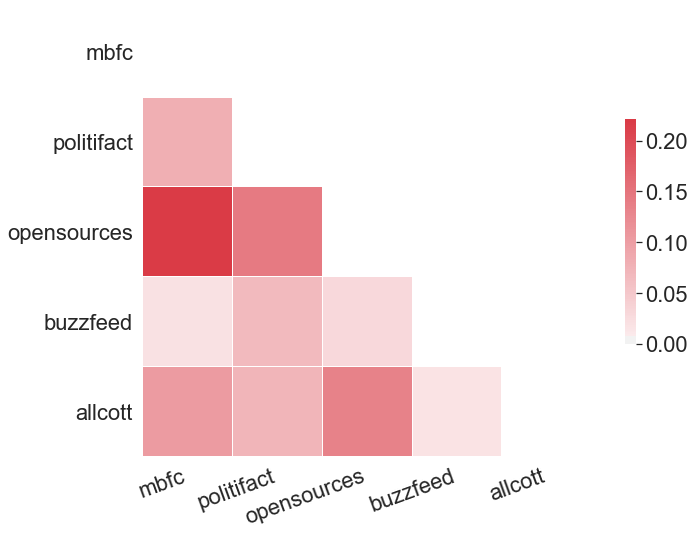

In [54]:
sources = ['mbfc', 'politifact', 'opensources', 'buzzfeed', 'allcott']

from matplotlib_venn import venn2


venn_sets = []
for source in sources:
    # get a temp dataframe that comes from that source
    df_temp = df_merged[df_merged['is_fake']]
    df_temp = df_temp[df_temp.source.apply(lambda x: source in x)]
    venn_sets.append(set(df_temp['domain']))
#     venn_sets.append(df_temp['domain'])


# Second way to invoke venn2 (only works for 2 sets though)
# pprint(venn_sets)
# venn2(venn_sets)
# plt.show()
 

num_intersection = []
for i in range(len(venn_sets)):
    for j in range(len(venn_sets)):
        if i == j:
            num_intersection.append(0)
        else:
            num_intersection.append(len(venn_sets[i].intersection(venn_sets[j]))  /  len(venn_sets[i].union(venn_sets[j])) )

# Generate a mask for the upper triangle

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(np.int32(220), np.int32(10), as_cmap=True)
cmap = sns.color_palette("ch:2.5,-.2,dark=.3")

print(sns.__version__)

# cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style="white", font_scale=2)

matplotlib.rcParams['figure.figsize'] = 11.7,8.27


num_intersection = np.array(num_intersection).reshape((len(venn_sets), len(venn_sets)))
mask = np.triu(np.ones_like(num_intersection, dtype=np.bool))
ax = sns.heatmap(num_intersection, xticklabels=sources, yticklabels=sources, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap=cmap)

ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
plt.savefig('fakenews_source_similarity')
# ax.rcParams.update({'font.size': 24})






In [ ]:

# df = pd.read_csv('~/Downloads/FB-shares---combined.csv')
# domains = [util.get_normalized_domain(url) for url in df['URL'] if type(url) == type('string')]
# len(domains)

# df_2 = pd.DataFrame(domains, columns=['domain'])
# df_2.to_csv('seed_files/allcott_fake_list.csv')


In [70]:


###### temp code, to generate csv files for reporting
import json
filename = '/Users/zc/Documents/TwitterBotProject/reverse_lookup_json/reverse_lookup_162_241_217_177_TIME_2020-03-25-11-12-06.json'
data = json.load(open(filename, 'r'))

df = pd.DataFrame(data['response']['domains'])

df_recent = df[df['last_resolved']>'2020-03-18']
for i in df_recent['name']:
    if 'new' in i or 'maga' in i or '.pro' in i or 'trump' in i:
        print(i)
df_recent.to_csv('malware_domains.csv')

set(df_concat['domain']).intersection(df_recent)

# df['domain']

2020maga.pro
3storymagazine.com
allaboutusa.pro
aznewsroundup.com
biznewsblog.com
blackamericannews.com
britishmedicalnews.com
chinesenflnews.com
chryslernews.com
d20news.com
digynews.com
district2news.com
dospalosnews.com
edantrump.com
elatednews.com
getnewstuff.com
ghnewsfilla.com
globalnewspros.xyz
gnfnews.com
got-news.com
hcworldnews.com
hinewai.org.nz
hnews.pro
ilmaga.pro
it-news.pro
jugadnews.com
ledinews.com
maga2020.pro
maganews.pro
magnanewspapers.com
newhopechurchnewport.com
newhopelatvia.com
news24h.pro
news3insider.com
news4utv.com
newseventsmedia.com
newsleno.com
newsmag.pro
newspapercollections.com
newsredar.com
newtonscannon.com
nycpost.pro
oldsledsnewmemories.com
oneworldpictures.com
onews.pro
pinewoodjournal.com
skydivenewengland.net
skydiving-newengland.com
thecubenews.com
xmaga2020.site
y2k-news.com
ytbnews.com


set()

In [114]:

###### temp code, get chrome extensions, and download those extensions, and extract search domains, and permissions 

###### get domains of those websites

filename = '/Users/zc/Documents/TwitterBotProject/malicious_domain/chrome_embed_link.txt'

import re
# text = '<p>Contents :</p><a href="https://w3resource.com">Python Examples</a><a href="http://github.com">Even More Examples</a>'

# print("Original string: ",text)
# print("Urls: ",urls)

from collections import Counter
chrome_url = Counter()
with open(filename) as f:
    for line in f.readlines():
#         if 'cnnews3' in line or 'TIME' in line:
#             print(line)
#             html_file = '/Users/zc/Documents/TwitterBotProject/malicious_domain/{}'.format(line[2:].strip())
            html_file = '/Users/zc/Documents/TwitterBotProject/malicious_domain/{}'.format(line.strip())
            with open(html_file, 'r') as file:
                text = file.read()
                urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
                
                if len(urls) == 0:
                    print(filename)
                else:
                    print(urls)
                
                for url in urls:
                    if 'chrome.google.com' in url and 'google-analytics' not in url \
                    and 'webstore/reviews' not in url and 'webstore/ajax/' not in url\
                    and 'cws-static' not in url and 'accounts.google.com' not in url\
                    and 'webstore/category' not in url and 'extensions/permalink' not in url\
                    and 'detail' in url:
                        chrome_url[url] += 1
#                 if len(urls) < 5:
#                     print(urls)
            

            
        
# you may also want to remove whitespace characters like `\n` at the end of each line
# content = [x.strip() for x in content] 

# http*chrome.google.com*

# https://chrome.google.com/webstore/detail/secure-web-searching/dopmojabcdlfbnppmjeaajclohofnbol



["https://chrome.google.com/webstore/detail/safe-browsing-checker/hpcnoikpdmeemodpjiiclgobemmbccmj';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/safe-browsing-checker/hpcnoikpdmeemodpjiiclgobemmbccmj';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/secure-web-surfing/enmjojmecjhakabinfcpbmkbcpdbgijh';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/browse-safer/deiiiklocnibjflinkfmefpofgcfhdga';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/npdfkclmbnoklkdebjfodpendkepbjek';", "https://getsecuredsearch.com/1501738800';"]
["ht

["https://chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/browse-safer/deiiiklocnibjflinkfmefpofgcfhdga';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/npdfkclmbnoklkdebjfodpendkepbjek';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/browse-safer/deiiiklocnibjflinkfmefpofgcfhdga';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/secure-web-surfing/enmjojmecjhakabinfcpbmkbcpdbgijh';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome.google.com/webstore/detail/secure-web-surfing/enmjojmecjhakabinfcpbmkbcpdbgijh';", "https://getsecuredsearch.com/1501738800';"]
["https://chrome

In [115]:
chrome_url.most_common()

[("https://chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj';",
  157),
 ("https://chrome.google.com/webstore/detail/secure-web-searching/dopmojabcdlfbnppmjeaajclohofnbol';",
  153),
 ("https://chrome.google.com/webstore/detail/npdfkclmbnoklkdebjfodpendkepbjek';",
  146),
 ("https://chrome.google.com/webstore/detail/secure-web-surfing/enmjojmecjhakabinfcpbmkbcpdbgijh';",
  143),
 ("https://chrome.google.com/webstore/detail/browse-safer/deiiiklocnibjflinkfmefpofgcfhdga';",
  134),
 ("https://chrome.google.com/webstore/detail/safe-browsing-checker/hpcnoikpdmeemodpjiiclgobemmbccmj';",
  72),
 ("https://chrome.google.com/webstore/detail/web-security-checker/enfgmdnkelcpecofafaaingdocmknanl';",
  15),
 ("https://chrome.google.com/webstore/detail/browsing-safety-checker/dopkmmcoegcjggfanajnindneifffpck';",
  9),
 ("https://chrome.google.com/webstore/detail/pkemkgkekbelcohkcbjpcepeogcagehl';",
  5)]

In [111]:
list(chrome_url.keys())

["https://chrome.google.com/webstore/detail/safe-browsing-checker/hpcnoikpdmeemodpjiiclgobemmbccmj';",
 "https://chrome.google.com/webstore/detail/secure-web-surfing/enmjojmecjhakabinfcpbmkbcpdbgijh';",
 "https://chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj';",
 "https://chrome.google.com/webstore/detail/browse-safer/deiiiklocnibjflinkfmefpofgcfhdga';",
 "https://chrome.google.com/webstore/detail/npdfkclmbnoklkdebjfodpendkepbjek';",
 "https://chrome.google.com/webstore/detail/secure-web-searching/dopmojabcdlfbnppmjeaajclohofnbol';",
 "https://chrome.google.com/webstore/detail/web-security-checker/enfgmdnkelcpecofafaaingdocmknanl';",
 "https://chrome.google.com/webstore/detail/browsing-safety-checker/dopkmmcoegcjggfanajnindneifffpck';",
 "https://chrome.google.com/webstore/detail/pkemkgkekbelcohkcbjpcepeogcagehl';"]

In [116]:
import subprocess

unique_id = set([])
for extension in list(chrome_url.keys()):
    extension = extension.replace("'", '').replace(";", '').replace('https://', '')
    parts = extension.split('/')
    print(extension)
    if len(parts) == 4:
        extension_name = parts[3]
        extension_id = parts[3]
    if len(parts) == 5:
        extension_name = parts[3]
        extension_id = parts[4]

    if '?' in extension_id:
        extension_id = extension_id.split('?')[0]
    if extension_id not in unique_id:
        unique_id.add(extension_id)
        # download the extension
        print(extension_id, extension_name)
        return_code = subprocess.call(['curl', '-L', '-o', "/Users/zc/Documents/TwitterBotProject/malicious_domain/chrome_extension/{}.zip".format(extension_id), "https://clients2.google.com/service/update2/crx?response=redirect&os=mac&arch=x86-64&nacl_arch=x86-64&prod=chromecrx&prodchannel=stable&prodversion=44.0.2403.130&x=id%3D{}%26uc".format(extension_id)], shell=False)
        print(return_code)
        return_code = subprocess.call(['unzip', '-d', "/Users/zc/Documents/TwitterBotProject/malicious_domain/chrome_extension/{}-source".format(extension_name), "/Users/zc/Documents/TwitterBotProject/malicious_domain/chrome_extension/{}.zip".format(extension_id)])
        print(return_code)
#         break

# unzip -d -o dopkmmcoegcjggfanajnindneifffpck-source dopkmmcoegcjggfanajnindneifffpck.zip

chrome.google.com/webstore/detail/safe-browsing-checker/hpcnoikpdmeemodpjiiclgobemmbccmj
hpcnoikpdmeemodpjiiclgobemmbccmj safe-browsing-checker
0
1
chrome.google.com/webstore/detail/secure-web-surfing/enmjojmecjhakabinfcpbmkbcpdbgijh
enmjojmecjhakabinfcpbmkbcpdbgijh secure-web-surfing
0
1
chrome.google.com/webstore/detail/safe-web-searching/hmmnhahdacolomjankkcljjocpaohkbj
hmmnhahdacolomjankkcljjocpaohkbj safe-web-searching
0
1
chrome.google.com/webstore/detail/browse-safer/deiiiklocnibjflinkfmefpofgcfhdga
deiiiklocnibjflinkfmefpofgcfhdga browse-safer
0
1
chrome.google.com/webstore/detail/npdfkclmbnoklkdebjfodpendkepbjek
npdfkclmbnoklkdebjfodpendkepbjek npdfkclmbnoklkdebjfodpendkepbjek
0
1
chrome.google.com/webstore/detail/secure-web-searching/dopmojabcdlfbnppmjeaajclohofnbol
dopmojabcdlfbnppmjeaajclohofnbol secure-web-searching
0
1
chrome.google.com/webstore/detail/web-security-checker/enfgmdnkelcpecofafaaingdocmknanl
enfgmdnkelcpecofafaaingdocmknanl web-security-checker
0
1
chrome.go

In [132]:
import os
import json
from pprint import pprint

top_extensions = set(['safe-web-searching',
'secure-web-searching',
'npdfkclmbnoklkdebjfodpendkepbjek',
'secure-web-surfing',
'browse-safer',
'safe-browsing-checker',
'privado-private-search',
# 'startpage-%E2%80%94-private-searc',
# 'start-page',
# 'homepage',
# 'my-startpage',
# 'privacy-badger',
# 'black-homepage',
'new-tab-startpage-search'])

record_extension = []
chrome_extension_directory = '/Users/zc/Documents/TwitterBotProject/malicious_domain/chrome_extension/'
for filename in os.listdir(chrome_extension_directory):
#     print(filename)
    if filename.endswith('.zip') or '.DS_Store' in filename:
        continue
        
    manifest_file = "{}{}/manifest.json".format(chrome_extension_directory, filename)
    manifest = json.load(open(manifest_file, 'r'))
    
    if 'chrome_settings_overrides' in manifest and 'permissions' in manifest:
            print(filename)
            pprint(manifest['name'])
            pprint(manifest['chrome_settings_overrides']['search_provider']['search_url'])
            pprint(manifest['permissions'])
            print()
            
            record_extension.append({
                'Extension Name': manifest['name'],
                'Permissions': manifest['permissions'],
                'Search URL': manifest['chrome_settings_overrides']['search_provider']['search_url']
            })

#         print('no override')
#         print(filename)
#         pprint(manifest.get('permissions'))
#         print()





secure-web-searching-source
'Secure Web Searching'
'https://goldssearch.com/search-bing?q={searchTerms}&appId=27&src=bar'
['tabs', 'webRequest', 'webRequestBlocking', 'http://*/', 'https://*/']

safe-browsing-checker-source
'Safe Browsing Checker'
'https://goodbyesearch.com/search-bing?q={searchTerms}&appId=20&src=bar'
['tabs', 'webRequest', 'webRequestBlocking', 'http://*/', 'https://*/']

secure-web-surfing-source
'Secure Web Surfing'
'https://protectedsearching.com/search-bing?q={searchTerms}&appId=25&src=bar'
['tabs', 'webRequest', 'webRequestBlocking', 'http://*/', 'https://*/']

pkemkgkekbelcohkcbjpcepeogcagehl-source
'Web Searching Security'
'https://goshsearch.com/search-bing?q={searchTerms}&appId=37&src=bar'
['tabs', 'webRequest', 'webRequestBlocking', 'http://*/', 'https://*/']

web-security-checker-source
'Web Security Checker'
'https://browsingsecurityhub.com/search-bing?q={searchTerms}&appId=15&src=bar'
['tabs', 'webRequest', 'webRequestBlocking', 'https://browsingsecurity

In [133]:
import pandas as pd
df = pd.DataFrame(record_extension)
df.to_clipboard()